<a target="_blank" href="https://colab.research.google.com/github/fintech-dl-hse/course/blob/main/seminars/01_seminar_mlp_autograd/01_seminar_mlp_autograd.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# MLP на PyTorch и автоматическое дифференцирование



## Организационные вопросы

### Домашки

* Дедлайны мягкие
* **Штрафы:** За просрочку за каждый день будет сниматься по 10% от оценки, но суммарно штраф не может быть более 30%. Жестких дедлайнов нет. Если сдаешь через 3 дня домашку, штраф 30%. Если сдаешь через месяц, штраф тоже 30%
* Автотесты - оценку получаете автоматически
* План выдачи домашек есть в репозитории. В 3 модуле много маленьких домашек. Дальше они постепенно усложняются.

### Квизы

* Дедлайн - дата экзамена
* Желательно сразу после занятия их сдавать
* Кол-во попыток не на что не влияет
* Без сделанных квизов, вы не будете допущены к экзамену




## План семинара

### Часть I: PyTorch MLP
* Знакомство с PyTorch (базовые интерфейсы, broadcasting)
* Работа с данными (make_moons)
* Определение модели MLP на PyTorch
* Функции потерь и обучение
* Роль нелинейностей
* Сравнение с SVM
* Батчинг и эффективность

### Часть II: Autograd и Backpropagation
* Как работает автоматическое дифференцирование?
* Forward и backward pass
* Chain rule и backpropagation
* Примеры autograd в PyTorch
* Реализация собственного autograd

### Блиц-вопросы
* Проверка понимания материала

---

# Часть I: PyTorch MLP

## Знакомство с PyTorch

PyTorch - библиотека для глубокого обучения, разработанная Meta (Facebook).

**Основные преимущества:**
* Интуитивный API (похож на NumPy)
* Динамический computational graph
* Удобные инструменты для GPU
* Автоматическое дифференцирование

### Аналогия с NumPy

PyTorch tensors работают очень похоже на NumPy arrays:

In [21]:
import torch
import numpy as np

# NumPy
np_array = np.array([1, 2, 3, 4, 5])
print("NumPy array:", np_array)
print("Shape:", np_array.shape)
print("Mean:", np_array.mean())

print()

# PyTorch (очень похоже!)
torch_tensor = torch.tensor([1, 2, 3, 4, 5])
print("PyTorch tensor:", torch_tensor)
print("Shape:", torch_tensor.shape)
print("Mean:", torch_tensor.float().mean())  # PyTorch требует float для mean()

NumPy array: [1 2 3 4 5]
Shape: (5,)
Mean: 3.0

PyTorch tensor: tensor([1, 2, 3, 4, 5])
Shape: torch.Size([5])
Mean: tensor(3.)


### Основные операции с тензорами

In [22]:
# Создание тензоров
a = torch.zeros(3, 4)        # Матрица 3x4 из нулей
b = torch.ones(3, 4)         # Матрица 3x4 из единиц
c = torch.rand(3, 4)         # Случайные числа [0, 1)
d = torch.randn(3, 4)        # Нормальное распределение N(0, 1)

print("Zeros:\n", a)
print("\nOnes:\n", b)
print("\nRandom uniform:\n", c)
print("\nRandom normal:\n", d)

Zeros:
 tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

Ones:
 tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])

Random uniform:
 tensor([[0.6057, 0.8140, 0.1160, 0.2760],
        [0.2885, 0.2483, 0.7573, 0.5793],
        [0.1443, 0.3085, 0.7692, 0.7457]])

Random normal:
 tensor([[ 1.7009,  0.8876, -0.9453, -0.6354],
        [ 0.9260,  0.1145, -1.3640,  0.1628],
        [ 0.7959,  0.3998, -1.6485,  0.1082]])


In [23]:
# Арифметические операции
x = torch.tensor([1.0, 2.0, 3.0])
y = torch.tensor([4.0, 5.0, 6.0])

print("x + y =", x + y)
print("x * y =", x * y)
print("x @ y =", x @ y)

x + y = tensor([5., 7., 9.])
x * y = tensor([ 4., 10., 18.])
x @ y = tensor(32.)


### Broadcasting в PyTorch

**Broadcasting** - механизм, позволяющий производить операции между тензорами разных размеров.

PyTorch автоматически "растягивает" тензоры меньшего размера, чтобы они совпадали по размерности.

**Правила broadcasting:**
1. Если тензоры имеют разное количество измерений, форма тензора с меньшим количеством измерений дополняется единицами слева
2. Размеры считаются совместимыми, если они равны или один из них равен 1
3. Тензоры расширяются по измерениям размером 1

Подробнее: [PyTorch Broadcasting Semantics](https://pytorch.org/docs/stable/notes/broadcasting.html)

In [25]:
# Пример 1: Вектор + скаляр
x = torch.tensor([1.0, 2.0, 3.0])  # shape: (3,)
scalar = 10.0                       # shape: ()

result = x + scalar
print("Вектор + скаляр:")
print(f"  {x.tolist()} + {scalar} = {result.tolist()}")
print(f"  Shapes: {x.shape} + () = {result.shape}")

print("\n\n")

# Пример 2: Матрица + вектор
matrix = torch.tensor([[1.0, 2.0, 3.0],
                        [4.0, 5.0, 6.0]])  # shape: (2, 3)
vector = torch.tensor([10.0, 20.0, 30.0])  # shape: (3,)

result = matrix + vector
print("Матрица + вектор:")
print("Matrix:\n", matrix)
print("Vector:", vector)
print("Result:\n", result)
print(f"Shapes: {matrix.shape} + {vector.shape} = {result.shape}")

Вектор + скаляр:
  [1.0, 2.0, 3.0] + 10.0 = [11.0, 12.0, 13.0]
  Shapes: torch.Size([3]) + () = torch.Size([3])



Матрица + вектор:
Matrix:
 tensor([[1., 2., 3.],
        [4., 5., 6.]])
Vector: tensor([10., 20., 30.])
Result:
 tensor([[11., 22., 33.],
        [14., 25., 36.]])
Shapes: torch.Size([2, 3]) + torch.Size([3]) = torch.Size([2, 3])


In [26]:
# Пример 3: Broadcasting в обе стороны
a = torch.tensor([[1.0],
                  [2.0],
                  [3.0]])  # shape: (3, 1)

b = torch.tensor([10.0, 20.0, 30.0])  # shape: (3,) → будет расширено до (1, 3)

result = a + b
print("Broadcasting в обе стороны:")
print("a (3, 1):\n", a)
print("b (3,):", b)
print("Result (3, 3):\n", result)
print(f"Shapes: {a.shape} + {b.shape} → {result.shape}")

Broadcasting в обе стороны:
a (3, 1):
 tensor([[1.],
        [2.],
        [3.]])
b (3,): tensor([10., 20., 30.])
Result (3, 3):
 tensor([[11., 21., 31.],
        [12., 22., 32.],
        [13., 23., 33.]])
Shapes: torch.Size([3, 1]) + torch.Size([3]) → torch.Size([3, 3])


### PyTorch vs NumPy: ключевые отличия

| Аспект | NumPy | PyTorch |
|--------|-------|---------|
| Основная структура | `ndarray` | `Tensor` |
| GPU поддержка | ❌ Нет | ✅ Да (`.cuda()`, `.to('cuda')`) |
| Autograd | ❌ Нет | ✅ Да (`.backward()`) |
| Модули | ❌ Нет | `nn.Module`, `nn.Linear`, `nn.ReLU`, ... |
| Broadcasting | ✅ Да | ✅ Да (те же правила) |

**Когда использовать PyTorch вместо NumPy:**
* Нужно обучать нейросети (autograd!)
* Нужны вычисления на GPU

#  Данные

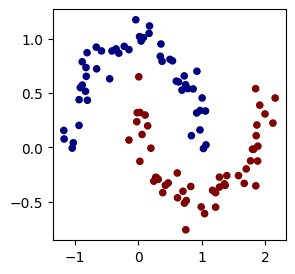

In [97]:
import numpy as np

from sklearn.datasets import make_moons, make_blobs
import matplotlib.pyplot as plt

X, y = make_moons(n_samples=100, noise=0.1, random_state=1)

plt.rcParams['figure.figsize'] = (3, 3)

# plt.figure(figsize=(5, 5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')



### Вопрос: разделимы ли линейно эти объекты?

### Вопрос: будут ли эти объекты линейро разделимы, если мы спроецируем их через линейное преобразование в 3D пространство? А в 1024D-мерное?


### Вопрос: Какой размер матрицы линейных преобразований для видео ниже?

# Torch MLP

<video controls>
    <source src="https://github.com/fintech-dl-hse/course/raw/refs/heads/main/seminars/01_seminar_mlp_autograd/static/01_DimensionalityExpansionScene.mp4" type="video/mp4">
    Your browser does not support the video tag.
</video>

## Определяем модель


### `Модель` = `Обучаемые Параметры` + `Граф вычислений`


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# initialize a model
class MLP(nn.Module):
    def __init__(self, activation_cls=nn.ReLU):
        super().__init__()

        self.input_layer  = nn.Linear(2, 100)       # Параметры модели # 2 * 100 + 100
        self.hidden_layer = nn.Linear(100, 100)     # Параметры модели # 100 * 100 + 100
        self.output_layer = nn.Linear(100, 1)       # Параметры модели # 100 * 1 + 1
        self.activation   = activation_cls()

        return

    def forward(self, x_coordinates):
        # x_coordinates ~ [ batch_size, 2 ]

        # latents - активации модели
        latents = self.activation(self.input_layer(x_coordinates)) # [ batch_size, 100 ]
        latents = self.activation(self.hidden_layer(latents))      # [ batch_size, 100 ]
        scores = self.output_layer(latents)                        # [ batch_size, 1 ]

        # latents = self.activation(self.input_layer(x_coordinates)) # [ batch_size, 100 ]
        # latents = self.activation(self.hidden_layer(latents))      # [ batch_size, 100 ]
        # scores = self.output_layer(latents)                        # [ batch_size, 1 ]
        scores = scores[:, 0]                                      # [ batch_size ]

        return scores


model = MLP()
print(model)
print("number of parameters", sum(p.numel() for p in model.parameters()))


MLP(
  (input_layer): Linear(in_features=2, out_features=100, bias=True)
  (hidden_layer): Linear(in_features=100, out_features=100, bias=True)
  (output_layer): Linear(in_features=100, out_features=1, bias=True)
  (activation): ReLU()
)
number of parameters 10501


**Вопрос:** Откуда берутся значения для скрытых размерностей?

**Вопрос:** Как мы определяем, для каких слоев нужно применять активации?

**Вопрос:** Что будет, если активации убрать?

In [99]:
print("Parameters shapes:")
print([p.shape for p in model.hidden_layer.parameters()])

Parameters shapes:
[torch.Size([100, 100]), torch.Size([100])]


In [100]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.5424,  0.7035],
         [ 0.4790, -0.5349],
         [-0.6747, -0.5768],
         [ 0.5443,  0.4128],
         [ 0.4504, -0.0185],
         [-0.0441, -0.2940],
         [ 0.2080,  0.0831],
         [ 0.6219, -0.2243],
         [-0.3513, -0.5343],
         [ 0.1016,  0.0229],
         [ 0.4938, -0.1573],
         [-0.6393,  0.6179],
         [-0.4360,  0.6501],
         [-0.3244, -0.5963],
         [ 0.1382, -0.2151],
         [ 0.2515,  0.0522],
         [-0.1192, -0.4686],
         [-0.3790, -0.6068],
         [ 0.6297,  0.0165],
         [ 0.0684, -0.3553],
         [-0.4688, -0.1745],
         [ 0.6979,  0.3253],
         [-0.2037, -0.0049],
         [-0.4023, -0.6557],
         [ 0.5090,  0.6831],
         [-0.6267,  0.4039],
         [ 0.0969, -0.3813],
         [-0.1846,  0.5267],
         [-0.5365, -0.1084],
         [ 0.1364,  0.2271],
         [-0.1810, -0.5180],
         [ 0.6308, -0.5346],
         [-0.2332,  0.5484],
         [ 0.5378, -

In [ ]:
rand_input = torch.randn(10, 2)
model(rand_input)

tensor([0.1878, 0.1784, 0.1558, 0.1262, 0.1683, 0.1631, 0.1518, 0.1705, 0.2363,
        0.1757], grad_fn=<SelectBackward0>)

In [ ]:
model.forward(rand_input) # ❌ Не бро! Используйте `model(rand_input)`. Если так вызывать, перестают работать хуки.

tensor([0.1878, 0.1784, 0.1558, 0.1262, 0.1683, 0.1631, 0.1518, 0.1705, 0.2363,
        0.1757], grad_fn=<SelectBackward0>)

## Вычисляем лосс

In [ ]:

# loss function
def loss(model, Xbatch, ybatch):

    Xbatch = torch.tensor(Xbatch).float() # [ batch_size, 2 ]

    # ybatch.max() == 1, ybatch.min() == -1
    ybatch = torch.tensor(ybatch).float().unsqueeze(-1) # [ batch_size, 1 ] values -1 or +1

    # forward the model to get scores
    model_prediction = model(Xbatch).unsqueeze(-1) # [ batch_size, 1 ]

    # svm "max-margin" loss
    losses = F.relu(1 - ybatch * model_prediction) # [ batch_size, 1 ]
    loss = losses.mean()

    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p).sum() for p in model.parameters())
    total_loss = loss + reg_loss

    # also get accuracy
    accuracy = ((ybatch > 0) == (model_prediction > 0)).float().mean()
    return total_loss, accuracy

total_loss, acc = loss(model, X, y * 2 - 1)
print(total_loss, acc)

tensor(0.0403, grad_fn=<AddBackward0>) tensor(0.9900)


In [114]:
# optimization

def train(model, learning_rate=0.1):

    Xbatch, ybatch = make_moons(n_samples=100, noise=0.1, random_state=1)
    ybatch = ybatch * 2 - 1 # make y be -1 or 1

    for k in range(500):

        model.zero_grad() # обнуляем градиенты с предыдущего шага

        # forward
        total_loss, acc = loss(model, Xbatch, ybatch)

        # backward
        total_loss.backward() # вычисляем новые значения градиентов
        # (model.linear_in.weight.grad)

        # шаг оптимизации
        # update (sgd)
        for p in model.parameters():
            p.data = p.data - learning_rate * p.grad

        if k % 50 == 0:
            print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")


model = MLP()

train(model, learning_rate=0.05)

step 0 loss 1.0487055778503418, accuracy 50.0%
step 50 loss 0.2285652905702591, accuracy 90.0%
step 100 loss 0.1479000747203827, accuracy 96.0%
step 150 loss 0.07872152328491211, accuracy 98.0%
step 200 loss 0.03752303496003151, accuracy 100.0%
step 250 loss 0.028173968195915222, accuracy 100.0%
step 300 loss 0.02207924798130989, accuracy 100.0%
step 350 loss 0.016065042465925217, accuracy 100.0%
step 400 loss 0.01666482351720333, accuracy 100.0%
step 450 loss 0.014333266764879227, accuracy 100.0%


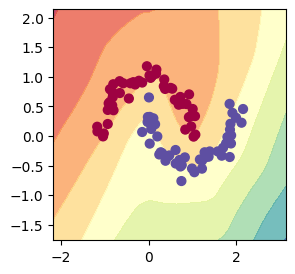

In [115]:
def visualize_model_prediction(model):

    h = 0.1
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))
    Xmesh = np.c_[xx.ravel(), yy.ravel()]

    if isinstance(model, nn.Module):
        with torch.no_grad():
            Xbatch = torch.tensor(Xmesh).float()

            scores = model.forward(Xbatch)
            Z = scores.numpy()

    else:
        scores = model.decision_function(Xmesh)
        Z = scores

    Z = Z.reshape(xx.shape)

    fig = plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

visualize_model_prediction(model)

### Видео

<video controls>
    <source src="https://github.com/fintech-dl-hse/course/raw/refs/heads/main/seminars/01_seminar_mlp_autograd/static/02_MLPNonlinearityScene.mp4" type="video/mp4">
    Your browser does not support the video tag.
</video>

## Вклад нелинейностей



step 0 loss 1.0066101551055908, accuracy 50.0%
step 50 loss 0.8999418020248413, accuracy 50.0%
step 100 loss 0.5979681611061096, accuracy 80.0%
step 150 loss 0.3988984227180481, accuracy 81.0%
step 200 loss 0.3534523844718933, accuracy 84.0%
step 250 loss 0.32687675952911377, accuracy 85.0%
step 300 loss 0.30983299016952515, accuracy 85.0%
step 350 loss 0.2987881898880005, accuracy 87.0%
step 400 loss 0.2956525385379791, accuracy 88.0%
step 450 loss 0.2913205325603485, accuracy 87.0%


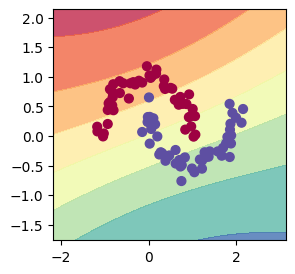

In [89]:
model = MLP(activation_cls=nn.Sigmoid)

train(model, learning_rate=0.1)
visualize_model_prediction(model)

step 0 loss 0.9899672269821167, accuracy 50.0%
step 50 loss 0.28781458735466003, accuracy 87.0%
step 100 loss 0.28761962056159973, accuracy 87.0%
step 150 loss 0.28734681010246277, accuracy 87.0%
step 200 loss 0.2873717248439789, accuracy 87.0%
step 250 loss 0.28734928369522095, accuracy 87.0%
step 300 loss 0.28723573684692383, accuracy 87.0%
step 350 loss 0.2872658371925354, accuracy 87.0%
step 400 loss 0.2872442603111267, accuracy 87.0%
step 450 loss 0.2872285544872284, accuracy 87.0%


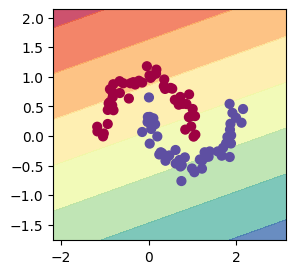

In [ ]:
# nn.Identity(x) == x
model = MLP(activation_cls=nn.Identity)

train(model, learning_rate=0.1)
visualize_model_prediction(model)

# SVM

In [91]:
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification


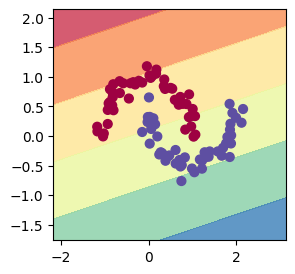

In [92]:
clf = LinearSVC(random_state=0)
clf.fit(X, y)
visualize_model_prediction(clf)

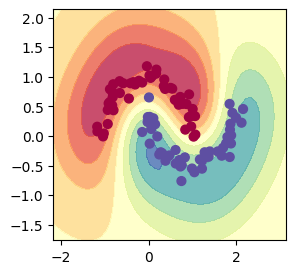

In [93]:
# визуализация SVM
# https://www.youtube.com/watch?v=OdlNM96sHio

clf = SVC(random_state=0, C=1.0, kernel='rbf')
clf.fit(X, y)
visualize_model_prediction(clf)

# Батчи и эффективность обучения / инференса

In [94]:
%%timeit

with torch.no_grad():
    Xbatch = torch.rand([1000, 2])
    model.forward(Xbatch)

160 µs ± 12.7 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [95]:
%%timeit

with torch.no_grad():
    Xbatch = torch.rand([1000, 2])
    for i in range(Xbatch.shape[0]):
        model.forward(Xbatch[i:i+1, :])

13.8 ms ± 465 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Резюме

## Часть I: PyTorch MLP

1. **MLP модель** = обучаемые параметры (Linear слои) + граф вычислений (метод `forward()`)
2. **Обучение**: `zero_grad()` → forward → `backward()` → SGD update
3. **Нелинейности критичны** - без них MLP эквивалентен линейной модели
4. **Батчинг** - обработка группы примеров одновременно для эффективности GPU

---

# Часть II: Как работает автоматическое дифференцирование?

На первой части мы использовали PyTorch как "черный ящик". Мы вызывали `loss.backward()` и магическим образом получали градиенты для всех параметров модели.

Но как это работает? Давайте разберемся!

## Зачем мы пилим автоград? 🤖

Чтобы не считать градиенты вручную! Ведь количество вариаций, как может быть построен граф вычислений в нейросетях очень большое - заранее все формулы для градиентов мы не сможем посчитать.

## Что мы запомнили на лекции? 🤷

* нейросеть -- это сложная функция (с параметрами), которая может быть представлена как композиция простых функций
* оптимизируем с помощью градиентного спуска

Чтобы эффективно обучать нейросети, нам нужно автоматически вычислять градиенты по всем параметрам.

## Как работать с автоградом? 🪄

От автограда нам нужно 2 вещи: **forward** и **backward pass**.

### **forward pass**
На этом этапе идет вычисление выхода сети: подаем вход, прогоняем через все слои, получаем предсказание.

### **backward pass**
На этом этапе вычисляются градиенты: начинаем с loss функции и идем назад по сети, вычисляя градиенты по всем параметрам с помощью chain rule.

# Backpropagation + Chain rule = ❤️

**Chain rule (правило дифференцирования сложной функции)**:

Если $F = f(g(x))$, то $\frac{dF}{dx} = \frac{dF}{dg} \cdot \frac{dg}{dx}$

Пример:
\begin{align*}
F &= (a + b) c  \\
q &= a + b  \\
F &= q c
\end{align*}

Тогда:
\begin{align*}
\frac{\partial F}{\partial a} &= \frac{\partial F}{\partial q} \cdot \frac{\partial q}{\partial a} = c \cdot 1 = c \\
\frac{\partial F}{\partial b} &= \frac{\partial F}{\partial q} \cdot \frac{\partial q}{\partial b} = c \cdot 1 = c \\
\frac{\partial F}{\partial c} &= q
\end{align*}

**Backpropagation** - это просто применение chain rule для вычисления градиентов в нейросети!

---

# Матричное дифференцирование

При работе с нейросетями мы постоянно имеем дело с векторами и матрицами. Чтобы эффективно вычислять градиенты, нам нужно понимать правила матричного дифференцирования.


## Основные правила матричного дифференцирования

### 1. Линейные операции

**Производная линейной формы:**
$$\frac{\partial (\mathbf{a}^T \mathbf{x})}{\partial \mathbf{x}} = \mathbf{a}$$

где $\mathbf{a}$ — константный вектор, $\mathbf{x}$ — переменная.



### 2. Матрично-векторное умножение

**Производная по вектору:**
$$\frac{\partial (W\mathbf{x})}{\partial \mathbf{x}} = W^T$$

**Производная по матрице:**
$$\frac{\partial (\mathbf{a}^T W \mathbf{x})}{\partial W} = \mathbf{a} \mathbf{x}^T$$

где результат — матрица размера $m \times n$ (внешнее произведение векторов).


In [ ]:
# Пример: градиенты линейного слоя в PyTorch
import torch

# Создаем данные
x = torch.randn(5)  # вход: вектор размера 5
W = torch.randn(3, 5, requires_grad=True)  # веса: матрица 3x5
b = torch.randn(3, requires_grad=True)  # bias: вектор размера 3

# Forward pass
z = W @ x + b  # z = Wx + b
z_loss = z.sum()  # простая функция потерь (сумма элементов)

# Backward pass
z_loss.backward()

print("Градиент по W:")
print(f"  Shape: {W.grad.shape}")
print(f"  Вычисляется как: dL/dz * x^T")
print()
print("Градиент по x:")
print(f"  Shape: {x.grad.shape}")
print(f"  Вычисляется как: W^T * dL/dz")
print()
print("Градиент по b:")
print(f"  Shape: {b.grad.shape}")
print(f"  Равен dL/dz")

Градиент по W:
  Shape: torch.Size([3, 5])
  Вычисляется как: dL/dz * x^T

Градиент по x:
  Shape: torch.Size([5])
  Вычисляется как: W^T * dL/dz

Градиент по b:
  Shape: torch.Size([3])
  Равен dL/dz


In [ ]:

with torch.no_grad():

    dL_dz = torch.ones(3)  # поскольку loss = z.sum(), градиент по z — единицы
    W_grad_manual = dL_dz.unsqueeze(1) * x.unsqueeze(0)  # [3, 1] * [1, 5] -> [3, 5]
    assert torch.allclose(W.grad, W_grad_manual)

W.grad

tensor([[-0.8201,  1.0999, -0.3426,  1.2751, -0.0349],
        [-0.8201,  1.0999, -0.3426,  1.2751, -0.0349],
        [-0.8201,  1.0999, -0.3426,  1.2751, -0.0349]])

In [ ]:
with torch.no_grad():
    dL_dz = torch.ones(3)  # поскольку loss = z.sum(), градиент по z — единицы
    x_grad_manual = W.T @ dL_dz
    assert torch.allclose(x.grad, x_grad_manual)

x.grad


tensor([-3.0243,  0.6626, -1.0309, -4.1175,  1.9773])

### Пример 2: Mean Squared Error (MSE)

Функция потерь: $L = \frac{1}{n} \|\mathbf{y}_{pred} - \mathbf{y}_{true}\|^2 = \frac{1}{n} \sum_{i=1}^n (y_{pred}^{(i)} - y_{true}^{(i)})^2$

**Градиент по предсказаниям:**
$$\frac{\partial L}{\partial \mathbf{y}_{pred}} = \frac{2}{n}(\mathbf{y}_{pred} - \mathbf{y}_{true})$$

Это показывает, что градиент направлен в сторону увеличения ошибки, и при обучении мы движемся в противоположную сторону (gradient descent).

In [69]:
# Проверяем градиент MSE
y_pred = torch.randn(10, requires_grad=True)
y_true = torch.randn(10)

# MSE loss
loss = ((y_pred - y_true) ** 2).mean()
loss.backward()

print("Предсказания:", y_pred.data[:5])
print("Истинные значения:", y_true[:5])
print("Градиент:", y_pred.grad[:5])
print()
print("Формула: dL/dy_pred = 2/n * (y_pred - y_true)")
manual_grad = 2 * (y_pred.data - y_true) / len(y_pred)
print("Ручной расчет:", manual_grad[:5])
print("Совпадает с PyTorch:", torch.allclose(y_pred.grad, manual_grad))

Предсказания: tensor([-1.7647, -0.8636,  1.6340,  1.3881,  0.5012])
Истинные значения: tensor([ 1.1041, -0.9428,  0.8048,  0.7661,  0.4751])
Градиент: tensor([-0.5738,  0.0158,  0.1658,  0.1244,  0.0052])

Формула: dL/dy_pred = 2/n * (y_pred - y_true)
Ручной расчет: tensor([-0.5738,  0.0158,  0.1658,  0.1244,  0.0052])
Совпадает с PyTorch: True


## Зачем это нужно?

1. **Понимание backpropagation**: Все градиенты в нейросетях вычисляются по этим правилам
2. **Оптимизация**: Знание формул помогает писать эффективный код
3. **Отладка**: Можно проверить правильность градиентов вручную
4. **Создание своих слоев**: При реализации custom layers нужно знать, как вычислять градиенты

## Полезные ресурсы

- [CS231n: Backpropagation](https://cs231n.github.io/optimization-2/) — объяснение backprop с примерами
- [PyTorch Autograd](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html) — как PyTorch вычисляет градиенты

# Рассмотрим пример, как работает autograd в PyTorch

In [70]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import random
import torch.nn as nn
import torch

### Как на градиенты влияет сложение?

\begin{align*}
c &= a + b \\
\frac {\partial c} {\partial a} &= 1 \\
\frac {\partial c} {\partial b} &= 1
\end{align*}

### Как на градиенты влияет умножение?

\begin{align*}
c &= a \cdot b \\
\frac {\partial c} {\partial a} &= b \\
\frac {\partial c} {\partial b} &= a
\end{align*}

In [71]:
a = torch.Tensor([10.])
a.requires_grad = True

b = torch.Tensor([10.])
b.requires_grad = True

с = a * b
с.backward()

a.grad, b.grad

(tensor([10.]), tensor([10.]))

## ReLU (Rectified Linear Unit)

В семинаре мы будем использовать ReLU в качестве функции активации:

$$
\text{ReLU}(x) = \max(0, x)
$$

Производная ReLU:

$$
\frac{d \text{ReLU}}{dx} = \begin{cases} 1, & x > 0 \\ 0, & x \leq 0 \end{cases}
$$

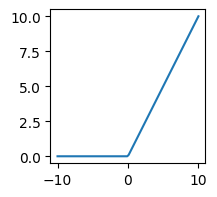

In [ ]:
import matplotlib.pyplot as plt
import torch

x = torch.linspace(-10, 10, 100)
y = torch.relu(x)
plt.figure(figsize=(2, 2))
plt.plot(x, y)
plt.show()

### Python magic methods

Python позволяет переопределять операторы через magic methods:

```python
Value(1) + Value(2)
# превращается в
Value(1).__add__(Value(2))
```

Мы будем использовать это, чтобы автоматически строить computational graph!

### Closures (замыкания)

Замыкание - это функция, которая "запоминает" переменные из внешней области видимости.

```python
def make_adder(x):
    def adder(y):
        return x + y  # x "запомнили" из внешней функции
    return adder

add_5 = make_adder(5)
print(add_5(10))  # 15
```

Мы будем использовать замыкания для хранения градиентных функций!

# Мы готовы сделать свой автоград!

### Видео

<video controls>
    <source src="https://github.com/fintech-dl-hse/course/raw/refs/heads/main/seminars/01_seminar_mlp_autograd/static/01_ComputationGraphScene.mp4" type="video/mp4">
    Your browser does not support the video tag.
</video>

## Класс Value - наш автоград

In [7]:
class Value:
    """Класс для автоматического дифференцирования."""

    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad  # d(a+b)/da = 1
            other.grad += out.grad  # d(a+b)/db = 1
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad  # d(a*b)/da = b
            other.grad += self.data * out.grad  # d(a*b)/db = a
        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad  # производная ReLU
        out._backward = _backward

        return out

    def backward(self):
        """Запускает backpropagation от этого узла."""
        # Топологическая сортировка
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        # Идем от выхода к входу и вычисляем градиенты
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

### Пример использования нашего autograd

In [11]:
# Пример: вычислим f(x, y) = x^2 + xy + (x + y)^2
x = Value(0.5)
y = Value(1)

a = x * x
b = x * y
c = x + y
d = a + b
e = c * c
f = d + e

print(f"f = {f.data}")

# Вычисляем градиенты
f.backward()

print(f"df/dx = {x.grad}")
print(f"df/dy = {y.grad}")

f = 3.0
df/dx = 5.0
df/dy = 3.5


<img src="https://github.com/fintech-dl-hse/course/raw/refs/heads/main/seminars/01_seminar_mlp_autograd/static/autograd_graph_example.png" width="600" />

In [ ]:
import numpy as np
import plotly.graph_objects as go

x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x, y)
Z = X**2 + X*Y + (X + Y)**2

fig = go.Figure(data=[go.Surface(x=X, y=Y, z=Z, colorscale='viridis')])
fig.update_layout(
    title=r'f(x,y) = x² + xy + (x+y)²',
    scene=dict(xaxis_title='x', yaxis_title='y', zaxis_title='z')
)
fig.show()

## Резюме по автограду

1. Chain Rule позволяет вычислять производные сложных функций за счет разбиения их на простые
2. forward pass строит вычислительный граф и сохраняет активации
3. Активации сохраняются, потому что они нужны для вычисления градиентов
4. Каждый слой вычисляет градиенты как по параметрам, так и по входам
5. Обратный проход обрабатывает узлы в обратном топологическом порядке



---

# Блиц-вопросы

## Часть I: PyTorch и MLP

1. В чем главное отличие PyTorch от NumPy?

2. Что такое broadcasting? Приведите пример.

3. Как луны может разделить логистическая регрессия?

4. Что будет, если убрать все нелинейности из нашей модели?

5. Что такое батч? Почему вычисления в нейросетях батчуются?


## Часть II: Autograd и Backpropagation

1. Зачем нужны функции активации в нейросетях?

2. Зачем нужен autograd? Почему нельзя вычислять градиенты вручную?

3. Когда вычисляются градиенты - во время forward или backward pass?

4. Какие градиенты нам нужны для обучения нейросети и зачем?

5. Как computational graph, построенный во время forward pass, используется при backward pass?

6. Как сложение и умножение влияют на градиенты?

7. Какой правильный порядок шагов при обучении нейросети?
   - a) forward → backward → zero_grad → optimizer.step
   - b) zero_grad → forward → backward → optimizer.step
   - c) backward → forward → zero_grad → optimizer.step

---

## Дополнительные материалы

* [PyTorch Documentation](https://pytorch.org/docs/stable/index.html)
* [PyTorch Tutorials](https://pytorch.org/tutorials/)
* [PyTorch Broadcasting Semantics](https://pytorch.org/docs/stable/notes/broadcasting.html)
* [Backpropagation Calculus](https://www.youtube.com/watch?v=tIeHLnjs5U8) - отличное видео от 3Blue1Brown
* [micrograd](https://github.com/karpathy/micrograd) - минималистичный autograd engine от Andrej Karpathy

---

# Домашка


Надо написать класс MLP с переменным количеством слоев.



---

# Квиз

1. Прямо сейчас нахдоим бота @fintech_dl_hse_bot и пишем ему /quiz в личку
2. Общаемся с ботом


![](http://qrcoder.ru/code/?https%3A%2F%2Ft.me%2Ffintech_dl_hse_bot&4&0)